In [2]:
# 정상 범위 기반 이상치 탐지 시스템
# SEMI_PHOTO_SENSORS 데이터 분석

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [6]:
# =============================================
# 설정 (Configuration)
# =============================================

# CSV 파일 경로
CSV_FILE_PATH = '/home/minjoo/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv'

# 정상 범위 정의
NORMAL_RANGES = {
    'EXPOSURE_DOSE': (20, 40),        # 20-40 mJ/cm²
    'FOCUS_POSITION': (-50, 50),      # ±50 nm
    'STAGE_TEMP': (22.9, 23.1),       # 23±0.1 °C
    'HUMIDITY': (40, 50),             # 45±5 %
    'ALIGNMENT_ERROR_X': (0, 3),      # <3 nm
    'ALIGNMENT_ERROR_Y': (0, 3),      # <3 nm
    'LENS_ABERRATION': (0, 5),        # <5 mλ
    'ILLUMINATION_UNIFORMITY': (98, 100),  # >98 %
    'RETICLE_TEMP': (22.95, 23.05)    # 23±0.05 °C
}

print("=" * 80)
print("정상 범위 기반 이상치 탐지 시스템")
print("=" * 80)
print(f"설정된 CSV 파일 경로: {CSV_FILE_PATH}")


정상 범위 기반 이상치 탐지 시스템
설정된 CSV 파일 경로: /home/minjoo/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv


In [7]:
# =============================================
# 1. 데이터 로딩 및 전처리
# =============================================

print("\n1. 데이터 로딩 및 전처리")
print("-" * 50)

import os
if not os.path.exists(CSV_FILE_PATH):
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {CSV_FILE_PATH}")

print(f"CSV 파일을 로딩합니다: {CSV_FILE_PATH}")
df = pd.read_csv(CSV_FILE_PATH)
print("파일 로딩 성공!")

# TIMESTAMP 컬럼을 datetime 형태로 변환
if 'TIMESTAMP' not in df.columns:
    raise ValueError(f"TIMESTAMP 컬럼이 없습니다. 현재 컬럼들: {list(df.columns)}")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
print("TIMESTAMP 컬럼 변환 완료!")

# 데이터 기본 정보 출력
print(f"데이터 형태: {df.shape}")
print(f"데이터 기간: {df['TIMESTAMP'].min()} ~ {df['TIMESTAMP'].max()}")
print(f"장비 수: {df['EQUIPMENT_ID'].nunique()}")
print(f"장비 목록: {list(df['EQUIPMENT_ID'].unique())}")


1. 데이터 로딩 및 전처리
--------------------------------------------------
CSV 파일을 로딩합니다: /home/minjoo/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv
파일 로딩 성공!
TIMESTAMP 컬럼 변환 완료!
데이터 형태: (35, 15)
데이터 기간: 2024-01-15 08:30:15 ~ 2024-02-02 08:46:05
장비 수: 3
장비 목록: ['PHO_001', 'PHO_002', 'PHO_003']


In [8]:
# =============================================
# 2. 정상 범위 출력
# =============================================

print("\n2. 정상 범위 정의")
print("-" * 50)
print("설정된 정상 범위:")
for param, (min_val, max_val) in NORMAL_RANGES.items():
    print(f"  {param}: {min_val} ~ {max_val}")


2. 정상 범위 정의
--------------------------------------------------
설정된 정상 범위:
  EXPOSURE_DOSE: 20 ~ 40
  FOCUS_POSITION: -50 ~ 50
  STAGE_TEMP: 22.9 ~ 23.1
  HUMIDITY: 40 ~ 50
  ALIGNMENT_ERROR_X: 0 ~ 3
  ALIGNMENT_ERROR_Y: 0 ~ 3
  LENS_ABERRATION: 0 ~ 5
  ILLUMINATION_UNIFORMITY: 98 ~ 100
  RETICLE_TEMP: 22.95 ~ 23.05


In [9]:
# =============================================
# 3. 정상 범위 기반 이상치 탐지 함수
# =============================================

def detect_range_based_anomalies(df, normal_ranges):
    """
    정상 범위를 벗어나는 이상치를 탐지하고 상세한 정보를 반환
    
    Parameters:
    - df: 데이터프레임
    - normal_ranges: 정상 범위 딕셔너리
    
    Returns:
    - anomaly_details: 이상치가 발견된 모든 행의 상세 정보
    - summary: 요약 정보
    """
    
    anomaly_details = []
    summary = {}
    
    # 각 행을 검사
    for idx, row in df.iterrows():
        row_anomalies = []
        
        # 각 파라미터에 대해 정상 범위 체크
        for param, (min_val, max_val) in normal_ranges.items():
            if param in row:
                value = row[param]
                if value < min_val or value > max_val:
                    row_anomalies.append({
                        'parameter': param,
                        'value': value,
                        'normal_min': min_val,
                        'normal_max': max_val,
                        'deviation': min(abs(value - min_val), abs(value - max_val))
                    })
        
        # 이상치가 발견된 행이면 상세 정보 저장
        if row_anomalies:
            anomaly_info = {
                'row_index': idx,
                'pno': row['PNO'],
                'equipment_id': row['EQUIPMENT_ID'],
                'lot_no': row['LOT_NO'],
                'wafer_id': row['WAFER_ID'],
                'timestamp': row['TIMESTAMP'],
                'anomalous_parameters': [item['parameter'] for item in row_anomalies],
                'anomaly_count': len(row_anomalies),
                'anomaly_details': row_anomalies,
                'full_row_data': row.to_dict()
            }
            anomaly_details.append(anomaly_info)
    
    # 요약 정보 생성
    for param in normal_ranges.keys():
        param_anomalies = [detail for detail in anomaly_details 
                          if param in detail['anomalous_parameters']]
        summary[param] = {
            'anomaly_count': len(param_anomalies),
            'percentage': (len(param_anomalies) / len(df)) * 100 if len(df) > 0 else 0
        }
    
    return anomaly_details, summary

In [10]:
# =============================================
# 4. 이상치 탐지 실행
# =============================================

print("\n3. 정상 범위 기반 이상치 탐지 실행")
print("-" * 50)

anomaly_details, summary = detect_range_based_anomalies(df, NORMAL_RANGES)

print(f"총 {len(anomaly_details)}개 행에서 이상치 발견")
print(f"전체 데이터의 {(len(anomaly_details)/len(df)*100):.2f}%")


3. 정상 범위 기반 이상치 탐지 실행
--------------------------------------------------
총 4개 행에서 이상치 발견
전체 데이터의 11.43%


In [11]:
# =============================================
# 5. 파라미터별 요약 정보
# =============================================

print("\n4. 파라미터별 이상치 요약")
print("-" * 50)

if summary:
    for param, info in summary.items():
        if info['anomaly_count'] > 0:
            print(f"{param}: {info['anomaly_count']}건 ({info['percentage']:.1f}%)")
else:
    print("모든 파라미터가 정상 범위 내에 있습니다.")



4. 파라미터별 이상치 요약
--------------------------------------------------
ILLUMINATION_UNIFORMITY: 4건 (11.4%)
RETICLE_TEMP: 2건 (5.7%)


In [12]:
# =============================================
# 6. 상세 이상치 정보 출력
# =============================================

print("\n5. 상세 이상치 정보")
print("-" * 50)

if anomaly_details:
    for i, anomaly in enumerate(anomaly_details, 1):
        print(f"\n[이상치 {i}]")
        print(f"행 인덱스: {anomaly['row_index']}")
        print(f"PNO: {anomaly['pno']}")
        print(f"장비 ID: {anomaly['equipment_id']}")
        print(f"LOT 번호: {anomaly['lot_no']}")
        print(f"웨이퍼 ID: {anomaly['wafer_id']}")
        print(f"측정 시간: {anomaly['timestamp']}")
        print(f"이상 파라미터 개수: {anomaly['anomaly_count']}")
        print(f"이상 파라미터 목록: {', '.join(anomaly['anomalous_parameters'])}")
        
        print("이상 파라미터 상세:")
        for detail in anomaly['anomaly_details']:
            print(f"  - {detail['parameter']}: {detail['value']:.3f} "
                  f"(정상범위: {detail['normal_min']} ~ {detail['normal_max']})")
        
        print("전체 행 데이터:")
        for key, value in anomaly['full_row_data'].items():
            if key != 'TIMESTAMP':
                print(f"  {key}: {value}")
            else:
                print(f"  {key}: {value}")
        print("-" * 60)
else:
    print("이상치가 발견되지 않았습니다. 모든 측정값이 정상 범위 내에 있습니다.")


5. 상세 이상치 정보
--------------------------------------------------

[이상치 1]
행 인덱스: 23
PNO: PS024
장비 ID: PHO_003
LOT 번호: LOT24009A
웨이퍼 ID: W001
측정 시간: 2024-01-23 08:15:20
이상 파라미터 개수: 2
이상 파라미터 목록: ILLUMINATION_UNIFORMITY, RETICLE_TEMP
이상 파라미터 상세:
  - ILLUMINATION_UNIFORMITY: 97.800 (정상범위: 98 ~ 100)
  - RETICLE_TEMP: 23.060 (정상범위: 22.95 ~ 23.05)
전체 행 데이터:
  PNO: PS024
  EQUIPMENT_ID: PHO_003
  LOT_NO: LOT24009A
  WAFER_ID: W001
  TIMESTAMP: 2024-01-23 08:15:20
  EXPOSURE_DOSE: 36.1
  FOCUS_POSITION: -25.3
  STAGE_TEMP: 23.02
  BAROMETRIC_PRESSURE: 1014.1
  HUMIDITY: 44.3
  ALIGNMENT_ERROR_X: 2.6
  ALIGNMENT_ERROR_Y: 2.8
  LENS_ABERRATION: 4.5
  ILLUMINATION_UNIFORMITY: 97.8
  RETICLE_TEMP: 23.06
------------------------------------------------------------

[이상치 2]
행 인덱스: 24
PNO: PS025
장비 ID: PHO_003
LOT 번호: LOT24009A
웨이퍼 ID: W002
측정 시간: 2024-01-23 08:16:05
이상 파라미터 개수: 1
이상 파라미터 목록: ILLUMINATION_UNIFORMITY
이상 파라미터 상세:
  - ILLUMINATION_UNIFORMITY: 97.900 (정상범위: 98 ~ 100)
전체 행 데이터:
  PNO: PS0

In [13]:
# =============================================
# 7. 장비별 이상치 분석
# =============================================

print("\n6. 장비별 이상치 분석")
print("-" * 50)

if anomaly_details:
    equipment_analysis = {}
    for anomaly in anomaly_details:
        equipment = anomaly['equipment_id']
        if equipment not in equipment_analysis:
            equipment_analysis[equipment] = {
                'total_anomalies': 0,
                'anomalous_measurements': 0,
                'parameters': {}
            }
        
        equipment_analysis[equipment]['anomalous_measurements'] += 1
        equipment_analysis[equipment]['total_anomalies'] += anomaly['anomaly_count']
        
        for param in anomaly['anomalous_parameters']:
            if param not in equipment_analysis[equipment]['parameters']:
                equipment_analysis[equipment]['parameters'][param] = 0
            equipment_analysis[equipment]['parameters'][param] += 1
    
    for equipment, analysis in equipment_analysis.items():
        total_measurements = len(df[df['EQUIPMENT_ID'] == equipment])
        anomaly_rate = (analysis['anomalous_measurements'] / total_measurements) * 100
        
        print(f"\n{equipment}:")
        print(f"  총 측정: {total_measurements}회")
        print(f"  이상 측정: {analysis['anomalous_measurements']}회 ({anomaly_rate:.1f}%)")
        print(f"  총 이상치: {analysis['total_anomalies']}개")
        print("  파라미터별 이상치:")
        for param, count in analysis['parameters'].items():
            print(f"    {param}: {count}회")


6. 장비별 이상치 분석
--------------------------------------------------

PHO_003:
  총 측정: 10회
  이상 측정: 4회 (40.0%)
  총 이상치: 6개
  파라미터별 이상치:
    ILLUMINATION_UNIFORMITY: 4회
    RETICLE_TEMP: 2회



7. 이상치 시각화
--------------------------------------------------


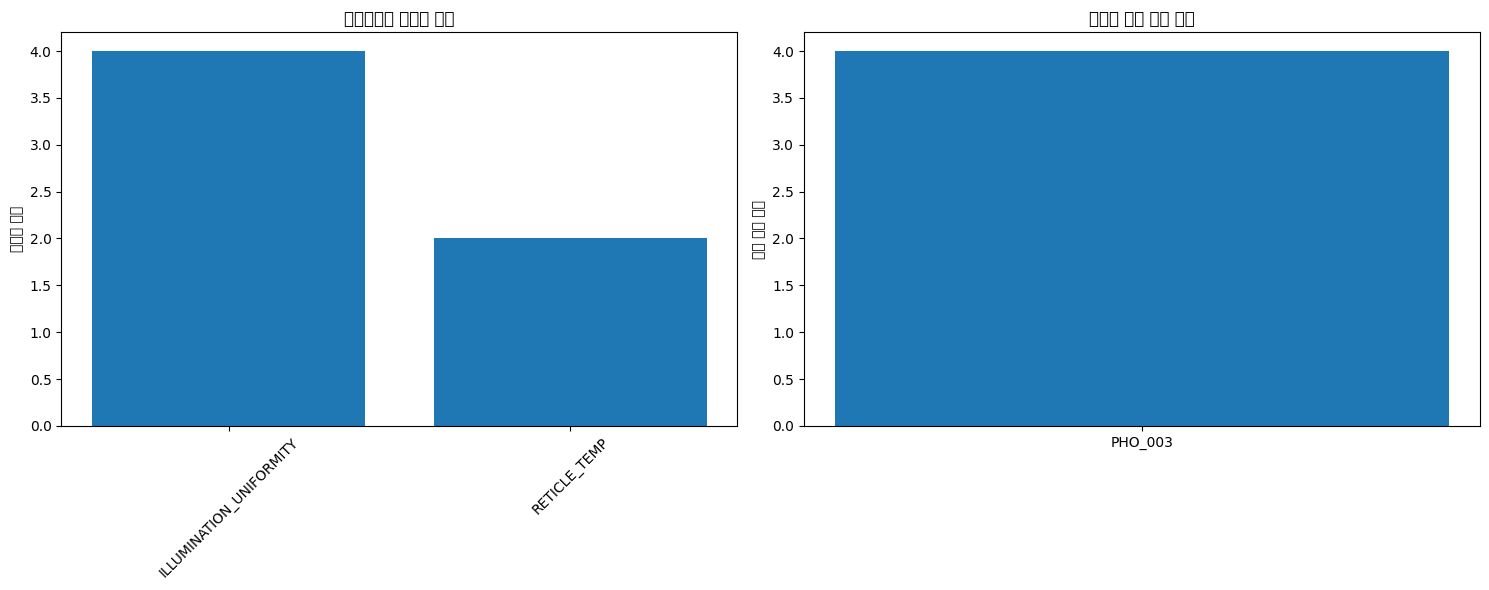

이상치 시각화 저장됨: range_based_anomalies.png


In [14]:
# =============================================
# 8. 시각화
# =============================================

print("\n7. 이상치 시각화")
print("-" * 50)

if anomaly_details:
    # 파라미터별 이상치 개수 막대 그래프
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 파라미터별 이상치 개수
    param_counts = {param: info['anomaly_count'] for param, info in summary.items() 
                   if info['anomaly_count'] > 0}
    
    if param_counts:
        ax1.bar(param_counts.keys(), param_counts.values())
        ax1.set_title('파라미터별 이상치 개수')
        ax1.set_ylabel('이상치 개수')
        ax1.tick_params(axis='x', rotation=45)
        
        # 장비별 이상치 개수
        if 'equipment_analysis' in locals():
            equipment_counts = {eq: analysis['anomalous_measurements'] 
                              for eq, analysis in equipment_analysis.items()}
            ax2.bar(equipment_counts.keys(), equipment_counts.values())
            ax2.set_title('장비별 이상 측정 개수')
            ax2.set_ylabel('이상 측정 개수')
    
    plt.tight_layout()
    plt.savefig('range_based_anomalies.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("이상치 시각화 저장됨: range_based_anomalies.png")

In [16]:
# =============================================
# 9. 결과 저장 함수
# =============================================

def save_anomaly_results(anomaly_details, filename='range_based_anomaly_results.csv'):
    """이상치 탐지 결과를 CSV 파일로 저장"""
    if not anomaly_details:
        print("저장할 이상치 데이터가 없습니다.")
        return
    
    # DataFrame으로 변환하여 저장
    rows = []
    for anomaly in anomaly_details:
        base_info = {
            'row_index': anomaly['row_index'],
            'pno': anomaly['pno'],
            'equipment_id': anomaly['equipment_id'],
            'lot_no': anomaly['lot_no'],
            'wafer_id': anomaly['wafer_id'],
            'timestamp': anomaly['timestamp'],
            'anomaly_count': anomaly['anomaly_count'],
            'anomalous_parameters': ', '.join(anomaly['anomalous_parameters'])
        }
        
        # 전체 행 데이터 추가
        base_info.update(anomaly['full_row_data'])
        rows.append(base_info)
    
    results_df = pd.DataFrame(rows)
    results_df.to_csv(filename, index=False, encoding='utf-8')
    print(f"이상치 결과 저장됨: {filename}")

In [17]:
# =============================================
# 10. 시간 구간별 이상치 탐지 함수
# =============================================

def detect_anomalies_by_time_range(df, start_time=None, end_time=None):
    """특정 시간 구간의 이상치 탐지"""
    
    # 시간 구간 필터링
    filtered_df = df.copy()
    if start_time:
        start_time = pd.to_datetime(start_time)
        filtered_df = filtered_df[filtered_df['TIMESTAMP'] >= start_time]
    if end_time:
        end_time = pd.to_datetime(end_time)
        filtered_df = filtered_df[filtered_df['TIMESTAMP'] <= end_time]
    
    if len(filtered_df) == 0:
        return [], {}, "지정된 시간 구간에 데이터가 없습니다."
    
    # 이상치 탐지 실행
    anomaly_details, summary = detect_range_based_anomalies(filtered_df, NORMAL_RANGES)
    
    period_info = f"분석 기간: {filtered_df['TIMESTAMP'].min()} ~ {filtered_df['TIMESTAMP'].max()}"
    
    return anomaly_details, summary, period_info

In [18]:
# =============================================
# 11. 사용 예시 및 완료 메시지
# =============================================

print("\n" + "=" * 80)
print("정상 범위 기반 이상치 탐지 완료")
print("=" * 80)

if anomaly_details:
    print(f"총 {len(anomaly_details)}개의 이상치가 탐지되었습니다.")
    print("상세한 이상치 정보가 위에 출력되었습니다.")
else:
    print("모든 측정값이 정상 범위 내에 있습니다.")

print("\n사용 가능한 함수들:")
print("# 결과 저장:")
print("save_anomaly_results(anomaly_details, 'my_results.csv')")
print("\n# 특정 시간 구간 분석:")
print("anomalies, summary, info = detect_anomalies_by_time_range(df, '2024-01-15', '2024-01-16')")

print("\n분석 완료!")


정상 범위 기반 이상치 탐지 완료
총 4개의 이상치가 탐지되었습니다.
상세한 이상치 정보가 위에 출력되었습니다.

사용 가능한 함수들:
# 결과 저장:
save_anomaly_results(anomaly_details, 'my_results.csv')

# 특정 시간 구간 분석:
anomalies, summary, info = detect_anomalies_by_time_range(df, '2024-01-15', '2024-01-16')

분석 완료!
